In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, log_loss
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings

#load the preprocessed data
X_train = pd.read_csv("X_train_bin.csv")
X_test = pd.read_csv("X_test_bin.csv")
y_train = pd.read_csv("y_train_bin.csv").squeeze()
y_test = pd.read_csv("y_test_bin.csv").squeeze()

In [2]:
# Suppress the specific XGBoost device mismatch warning
warnings.filterwarnings(
    'ignore',
    message='Falling back to prediction using DMatrix due to mismatched devices',
    category=UserWarning
)

In [4]:
#define the hyperparameter distributions
params = {
    'max_depth': stats.randint(2, 20),
    'learning_rate': stats.uniform(0.01, 0.3),
    'subsample': stats.uniform(0.05, 0.8),
    'n_estimators':stats.randint(50, 1500)
}

#create the XGBoost model
xgb_model = xgb.XGBClassifier(
    device = 'cuda'
)

#create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=20, cv=20, scoring='accuracy',verbose=4, random_state=42)

#conduct the hyperparameter search
random_search.fit(X_train, y_train)

Fitting 20 folds for each of 20 candidates, totalling 400 fits
[CV 1/20] END learning_rate=0.12236203565420874, max_depth=16, n_estimators=1180, subsample=0.6737528002182155;, score=1.000 total time=  18.2s
[CV 2/20] END learning_rate=0.12236203565420874, max_depth=16, n_estimators=1180, subsample=0.6737528002182155;, score=1.000 total time=  18.4s
[CV 3/20] END learning_rate=0.12236203565420874, max_depth=16, n_estimators=1180, subsample=0.6737528002182155;, score=1.000 total time=  18.7s
[CV 4/20] END learning_rate=0.12236203565420874, max_depth=16, n_estimators=1180, subsample=0.6737528002182155;, score=1.000 total time=  19.5s
[CV 5/20] END learning_rate=0.12236203565420874, max_depth=16, n_estimators=1180, subsample=0.6737528002182155;, score=1.000 total time=  19.0s
[CV 6/20] END learning_rate=0.12236203565420874, max_depth=16, n_estimators=1180, subsample=0.6737528002182155;, score=1.000 total time=  18.6s
[CV 7/20] END learning_rate=0.12236203565420874, max_depth=16, n_estimato

RandomizedSearchCV(cv=20,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constr...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000247D530BD90>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000247D530BB10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024767656B10>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024767656EA0>},
                   random_state=42, scoring='accuracy', verbose=4)

In [6]:
#print best parameters
print("Best set of hyperparameters: ", random_search.best_params_)

Best set of hyperparameters:  {'learning_rate': np.float64(0.05286004537658223), 'max_depth': 4, 'n_estimators': 1382, 'subsample': np.float64(0.8259278817295955)}


In [7]:
search_alg = random_search

#predict on the test set
y_pred = search_alg.best_estimator_.predict(X_test)
y_pred_proba = search_alg.best_estimator_.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

In [8]:
#calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
logloss = log_loss(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Log Loss: {logloss}")

Accuracy: 0.9999680727430622
Recall: 0.9998864571801641
Precision: 0.9999716118775904
F1 Score: 0.9999290327159179
ROC AUC: 0.9999999615293799
Log Loss: 0.00013689076631009234


In [9]:
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    242754
           1       1.00      1.00      1.00     70458

    accuracy                           1.00    313212
   macro avg       1.00      1.00      1.00    313212
weighted avg       1.00      1.00      1.00    313212



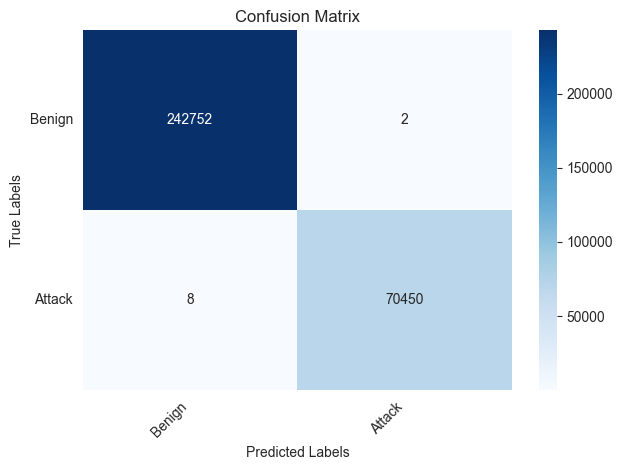

In [10]:
labels = [
    'Benign',
    'Attack'
]
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()